In [176]:
#Fetching tweets
from twitterscraper import query_tweets

import datetime as dt 
import time

#Dataframe
import pandas as pd 

# Numpy array
import numpy as np

#Extracting languages
import cld3

#Regex for preprocessing
import re

#Counting
from collections import Counter

#Plotting words
from wordcloud import WordCloud

#Disable pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None;  # default='warn'

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

#Matplotlib and seaborn plotting
from matplotlib import pyplot as plt
import seaborn as sns

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, GlobalMaxPool1D
from keras import utils

# Word2vec
import gensim

import spacy

In [4]:
#nltk.download('wordnet')

## Training Twitter model using `Sentiment140` dataset

In [2]:
sent_df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1")
sent_df.columns = ["target", "id", "date", "flag", "user", "text"]
sent_df.head()

,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


### Dataset Information
  
- **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- **ids**: The id of the tweet ( 2087)
- **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
- **user**: the user that tweeted (robotickilldozr)
- **text**: the text of the tweet (Lyx is cool)

In [9]:
print("Shape of dataset:", (sent_df).shape)

Shape of dataset: (1599999, 6)


In [29]:
sent_df['target'].unique()

array([0, 4])

### Assigning target labels to sentiments
- **0** -> **negative**
- **4** -> **positive**

In [3]:
sentiment_label = {0: "negative", 4: "positive"}
def sentiment_code(label):
    return sentiment_label[int(label)]

In [4]:
sent_df['target'] = sent_df['target'].apply(lambda x: sentiment_code(x))

In [35]:
sent_df['target'].unique()

array(['negative', 'positive'], dtype=object)

In [38]:
target_counts = Counter(sent_df['target'])

Text(0.5, 1.0, 'Sentiment Labels Distribution')

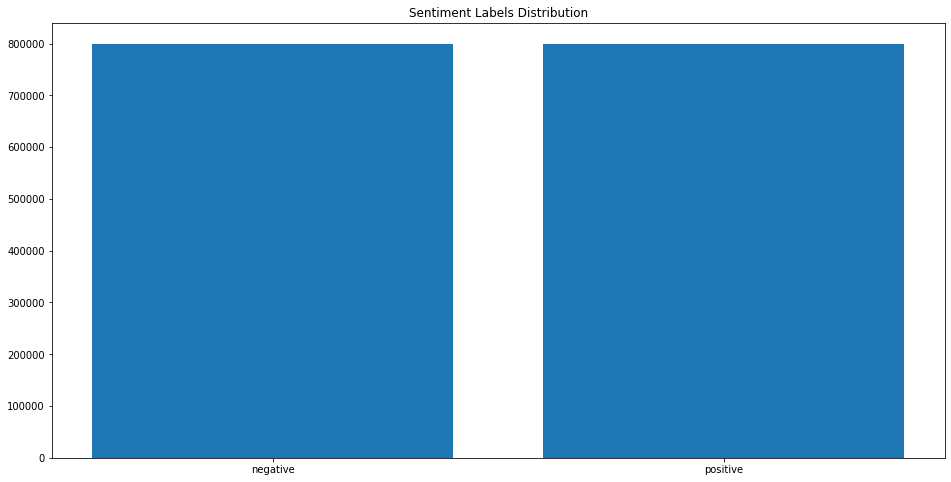

In [39]:
#Plotting
plt.figure(figsize=(16,8))
plt.bar(target_counts.keys(), target_counts.values())
plt.title("Sentiment Labels Distribution")

### Pre-preprocess Data

In [5]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")

In [30]:
def preprocess(text, lemmatize=True):
    # Remove url, handles, picture links, and special characters
    text = re.sub("pic\S*\s?|@\S+|http\S+|[^A-Za-z0-9]+", " ", str(text).lower()).strip()
    text = ' '.join([word for word in text.split() if word not in (stop)])
    
    if lemmatize:
        word_list = nltk.word_tokenize(text)
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
        return lemmatized_output#" ".join(tokens)
    else:
        return text

In [31]:
%%time
sent_df['prep_text'] = sent_df['text'].apply(lambda x: preprocess(x))

CPU times: user 3min 56s, sys: 992 ms, total: 3min 57s
Wall time: 3min 58s


In [32]:
sent_df.head()

,target,id,date,flag,user,text,prep_text
0,negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
1,negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save 50 rest go b...
2,negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behaving mad see
4,negative,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,whole crew


### Train test split

In [33]:
train_sent_df, test_sent_df = train_test_split(sent_df, train_size=0.8, random_state=1)
print("Train size:", train_sent_df.shape)
print("Test size:", test_sent_df.shape)

Train size: (1279999, 7)
Test size: (320000, 7)


### Word2Vec

In [131]:
docs = [text.split() for text in train_sent_df.prep_text] 

w2v_size = 256
w2v_window = 7
w2v_mincount = 10

w2v_model = gensim.models.word2vec.Word2Vec(size=w2v_size, 
                                            window=w2v_window, 
                                            min_count=w2v_mincount, 
                                            workers=8)

In [132]:
w2v_model.build_vocab(docs)

In [133]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 27346


In [134]:
w2v_epoch = 32
w2v_model.train(docs, total_examples=len(docs), epochs=w2v_epoch)

(262213330, 295965408)

In [135]:
w2v_model.wv.most_similar("epidemic")

[('phobia', 0.33858710527420044),
 ('creeping', 0.3338102102279663),
 ('disease', 0.32641810178756714),
 ('sanitizer', 0.31508469581604004),
 ('hygiene', 0.31486523151397705),
 ('glutton', 0.3026622533798218),
 ('obsession', 0.30033716559410095),
 ('prevention', 0.2932150661945343),
 ('plague', 0.2914431095123291),
 ('flu', 0.29043853282928467)]

In [136]:
w2v_model.wv.most_similar("food")

[('meat', 0.5062325596809387),
 ('meal', 0.49730384349823),
 ('pizza', 0.4938651919364929),
 ('dinner', 0.487648606300354),
 ('takeaway', 0.47706326842308044),
 ('seafood', 0.46645545959472656),
 ('durian', 0.4644070267677307),
 ('pasta', 0.46115943789482117),
 ('buffet', 0.45735859870910645),
 ('breakfast', 0.4571986198425293)]

### Data Preparation: Tokenizing and  Sequence padding

In [137]:
tokenizer = Tokenizer()

In [192]:
def prep_data(text, maxlen = 256, train = True):
        """              
        Encodes train data into vocabulary index for training mode, transforms each text
        in corpus to sequence of integers and returns sequence of 
        words in form of chain of index padded to same length.

        Parameters
        -----------
        text : str
          Texts to be trained
        mode : str
          Indicates corpus purpose (train or test)

        Return
        -----------
        numpy.array
          pad sequences of same length
        """
        
        # fit the tokenizer on the text
        if train:
            tokenizer.fit_on_texts(text)

            print("Vocabulary size", len(tokenizer.word_index) + 1)
        
        # integer encode documents
        encoded_text = tokenizer.texts_to_sequences(text)
        #print(encoded_text)
        print('length of encoded docs: ', len(encoded_text))
        
        #padding
        padded_data = pad_sequences(encoded_text, maxlen=maxlen)
        print('Padded data shape:', padded_data.shape)
        return padded_data 

In [193]:
X_train = prep_data(train_sent_df['prep_text'])

Vocabulary size 279806
length of encoded docs:  1279999
Padded data shape: (1279999, 256)


In [194]:
X_test = prep_data(test_sent_df['prep_text'], train = False)

length of encoded docs:  320000
Padded data shape: (320000, 256)


In [141]:
X_train

array([[    0,     0,     0, ...,    30,   668,    79],
       [    0,     0,     0, ...,  1349,  1317, 98049],
       [    0,     0,     0, ...,    20,   145,    14],
       ...,
       [    0,     0,     0, ...,    28,   939,    77],
       [    0,     0,     0, ...,     0,    34,  4244],
       [    0,     0,     0, ...,    35,   151,    44]], dtype=int32)

In [142]:
X_test

array([[    0,     0,     0, ...,   665,    32, 56311],
       [    0,     0,     0, ...,    41,   955,  2661],
       [    0,     0,     0, ...,    22,   170,  7573],
       ...,
       [    0,     0,     0, ...,  4594,   625,   322],
       [    0,     0,     0, ...,    12, 17782,    60],
       [    0,     0,     0, ...,  8811,    36,    23]], dtype=int32)

In [149]:
vocab_size = len(tokenizer.word_index)+1
print("Vocabulary Size", vocab_size)

Vocabulary Size 279806


In [51]:
labels = train_sent_df['target'].unique().tolist()
labels.append('neutral')
labels

['negative', 'positive', 'neutral']

### Label Encoding

In [156]:
encoder = LabelEncoder()
encoder.fit(train_sent_df['target'].tolist())

y_train = encoder.transform(train_sent_df['target'].tolist())
y_test = encoder.transform(test_sent_df['target'].tolist())

print("Shape of y_train",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of y_train (1279999,)
Shape of y_test (320000,)


In [157]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("New shape of y_train",y_train.shape)
print("New shape of y_test",y_test.shape)

New shape of y_train (1279999, 1)
New shape of y_test (320000, 1)


In [158]:
y_train

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [159]:
len(y_train == 0)

1279999

In [160]:
len(y_train != 0)

1279999

In [161]:
y_test

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [162]:
len(y_test==0)

320000

In [163]:
len(y_test!=0)

320000

### Creating Embedding layer

In [172]:
def embedding(vocab_size, w2v_size):
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    for word, integer in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[integer] = w2v_model.wv[word]
    print(embedding_matrix.shape)
    return embedding_matrix

embedding_matrix = embedding(vocab_size, w2v_size)

(279806, 256)


In [173]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67336804,  0.51442784,  0.3116945 , ...,  0.85701269,
         0.29912725, -1.50726855],
       [-0.41978836,  0.10511671, -0.64023268, ..., -0.71537638,
         0.42903075,  1.08060491],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Building Models

In [185]:
def build_model(vocab_size, w2v_size, input_length = 256, weights=[embedding_matrix], dropout_amount=0.5):
        """
        Given layer_size and dropout_amount, build an LSTM network
        using Keras and tensorflow and print summary of the model. 

        Parameters
        -----------
        layer_size : int
          The number of units to be passed in the LSTM layer
        dropout_amount : float
          the dropout amount to be passed in the Dropout layer. 

        Return
        -----------
        None
          print the summary of the model 
        """      
        model = Sequential()

        model.add(Embedding(vocab_size, w2v_size, weights = weights, input_length=input_length, trainable=False))

        model.add(LSTM(units = 256, dropout=dropout_amount, 
                       return_sequences=True, 
                       recurrent_dropout =  dropout_amount))
        
        model.add(GlobalMaxPool1D())
        model.add(Dropout(dropout_amount))
        model.add(Dense(20000, activation="relu"))
        model.add(Dropout(dropout_amount))
        model.add(Dense(1, activation='sigmoid'))
       
        model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        print(model.summary())
        return model
    


In [189]:
model = build_model(vocab_size, w2v_size, input_length = 256, weights=[embedding_matrix], dropout_amount=0.5)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 256, 256)          71630336  
_________________________________________________________________
lstm_6 (LSTM)                (None, 256, 256)          525312    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 20000)             5140000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [190]:
def fit(X_train, y_train, batch_size = 32, epochs = 10):
        """        
        Given the parameters train a deep learning model and save and return it.  
        
        Parameters
        -------------
        X_train : (list) 
          the X values of the train split 
        y_train : (list) 
          the y values of the train split 
        batch_size : (int) 
          the batch_size for the training
        epochs : (int) 
          the number of epochs for training 
        save_path : (str) the path to save the model
        
        Return
        -------------
          the trained model
        """      
        # YOUR CODE HERE 
        model.fit(X_train, y_train, 
                  batch_size=batch_size, epochs=epochs
                  )
        return model

In [ ]:
model.fit(X_train, y_train)

## Fetching and saving data

In [3]:
def fetch_tweets(query, start_date, end_date, limit = 10000, language = "English"):
    """
    start_date: date in form year,month,day
    """

    tweets = query_tweets(query, begindate = start_date, enddate = end_date, limit = limit, lang = language)
    df = pd.DataFrame(t.__dict__ for t in tweets)
    return df

In [32]:
start_date2 = dt.date(2020,2,1)
end_date2 = dt.date(2020,2,28)

start_date3 = dt.date(2020,3,1)
end_date3 = dt.date(2020,3,31)

start_date4 = dt.date(2020,4,1)
end_date4 = dt.date(2020,5,1)

limit = 25000
query = "coronavirus OR covid OR covid19 OR covid-19 OR corona virus OR #COVID19, OR #CoronavirusOutbreak" 

In [ ]:
tweets2 = fetch_tweets(query, start_date2, end_date2, limit = limit, language = 'english')

In [24]:
tweets2.shape

(13935, 21)

In [21]:
tweets2.to_csv (r'./data/tweets2.csv', index = False, header=True)

In [ ]:
tweets3 = fetch_tweets(query, start_date3, end_date3, limit = limit, language = 'english')

In [31]:
tweets3.shape

(13767, 21)

In [25]:
tweets3.to_csv (r'./data/tweets3.csv', index = False, header=True)

In [ ]:
tweets4 = fetch_tweets(query, start_date4, end_date4, limit = limit, language = 'english')

In [35]:
tweets4.to_csv (r'./data/tweets4.csv', index = False, header=True)

In [34]:
tweets4.shape

(13552, 21)

In [49]:
tweets = pd.concat([tweets2, tweets3, tweets4])
tweets.to_csv (r'./data/tweets.csv', index = False, header=True)

In [5]:
tweets.head()

,screen_name,username,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,text,text_html,links,...,has_media,img_urls,video_url,likes,retweets,replies,is_replied,is_reply_to,parent_tweet_id,reply_to_users
0,geziel_goes,Dr. Geziel Goes🇧🇷🇵🇹,4867434249,1233180006743969792,/geziel_goes/status/1233180006743969792,2020-02-27 23:59:59,1582847999,Se o Coronavirus esta derrubando a bolsa no Br...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],NaN,0,0,0,False,False,NaN,[]
1,Covid_19Time,COVID-19,1146021318082609152,1233180006655909888,/Covid_19Time/status/1233180006655909888,2020-02-27 23:59:59,1582847999,#Coronavirus #COVID19 \n\nIt’s going global @...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://twitter.com/Covid_19Time/status/1227...,...,True,['https://pbs.twimg.com/media/ER0irN5U0AADXHK....,NaN,26,8,2,True,False,NaN,[]
2,29Toninho,Toninho,585940381,1233180004030152704,/29Toninho/status/1233180004030152704,2020-02-27 23:59:58,1582847998,Bien por esa acción. Es difícil navegar por el...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],NaN,0,0,0,False,True,1.233054e+18,"[{'screen_name': 'Anaro74', 'user_id': '104697..."
3,BrendynMorgan,b,263311303,1233180001496969222,/BrendynMorgan/status/1233180001496969222,2020-02-27 23:59:58,1582847998,This damn Corona virus knocked my stocks all t...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],NaN,1,0,0,False,False,NaN,[]
4,BlindedSteer,Dusty Arth,460892027,1233179999605145600,/BlindedSteer/status/1233179999605145600,2020-02-27 23:59:57,1582847997,"@billburr So how many people are you secretly,...","<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],NaN,0,0,0,False,False,NaN,[]


In [25]:
#Extract language of each tweet 
tweets['text'] = tweets['text'].apply(lambda x:str(x)) #remove floats

tweets['language'] = tweets['text'].apply(cld3.get_language).map(lambda x: x[0]) #Get the language of each tweet

In [28]:
tweets[['text', 'language']]

,text,language
0,Se o Coronavirus esta derrubando a bolsa no Br...,pt
1,#Coronavirus #COVID19 \n\nIt’s going global @...,no
2,Bien por esa acción. Es difícil navegar por el...,es
3,This damn Corona virus knocked my stocks all t...,mg
4,"@billburr So how many people are you secretly,...",en
...,...,...
41249,"There it is folks, 18 months of lockdown minim...",en
41250,Do us a favor @realDonaldTrump just STFU when ...,en
41251,#ThankYOUgina !!!\nWhat an amazing woman! Amer...,en
41252,@GovSisolak The only thing you would be gratef...,en


## Obtain English tweets of interest

In [29]:
english_tweets = tweets[tweets['language']=='en']
english_tweets[['text', 'language']]

,text,language
4,"@billburr So how many people are you secretly,...",en
5,What a smart thinking! While other countries s...,en
6,"Live!! Pope Sick With Corona Virus, 8 Chan Fou...",en
9,PM says #coronavirus is 10x more severe than f...,en
11,I'm obviously not a seasoned economist but my ...,en
...,...,...
41248,I’ll only ever hear corona virus in Cardi B’s ...,en
41249,"There it is folks, 18 months of lockdown minim...",en
41250,Do us a favor @realDonaldTrump just STFU when ...,en
41251,#ThankYOUgina !!!\nWhat an amazing woman! Amer...,en


In [30]:
english_tweets.shape

(20246, 22)

## Preprocess tweets

In [40]:
english_tweets['prep_text'] = english_tweets['text'].apply(preprocess)

In [49]:
english_tweets['prep_text']

4        billburr mani peopl secretli deep kinda sorta ...
5        smart think countri itali switzerland austria ...
6        live pope sick corona viru chan founder run so...
9        pm say coronaviru x sever flu viru time sever ...
11       obvious season economist instinct blame stock ...
                               ...                        
41248                   ever hear corona viru cardi b voic
41249    folk month lockdown minimum forc vaccin newwor...
41250    us favor realdonaldtrump stfu come corona viru...
41251    thankyougina amaz woman america winner covid c...
41252    govsisolak thing would grate lazi fat fuck som...
Name: prep_text, Length: 20246, dtype: object

## Dropping Duplicates

In [70]:
english_tweets = english_tweets.drop_duplicates(subset='text')

In [73]:
word_to_list = [word for line in english_tweets['prep_text'] for word in line.split()]
word_to_list[:20]

['billburr', 'mani', 'peopl', 'secretli', 'deep', 'kinda', 'sorta', 'hope', 'corona', 'viru', 'take', 'billi', 'billion', 'peopl', 'shhh', 'bud', 'tell', 'smart', 'think', 'countri']

## Plotting Word Occurrence

In [74]:
occurence = Counter(word_to_list).most_common(50)
occurence_df = pd.DataFrame(occurence, columns=['stemmed_word', 'frequency'])

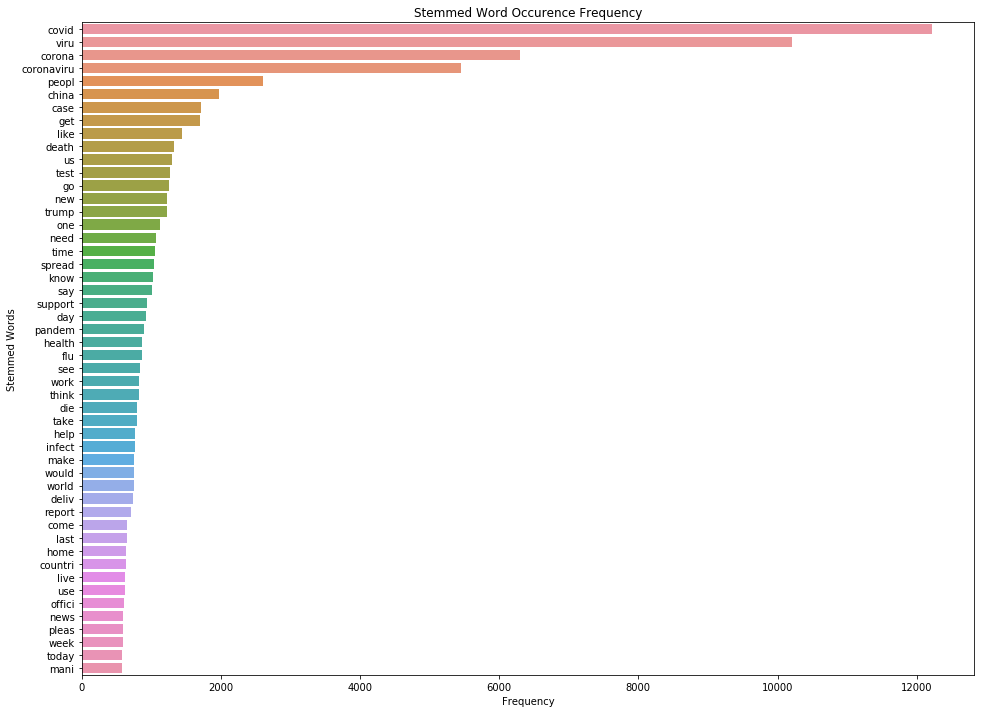

In [75]:
fig, ax = plt.subplots(figsize = (16, 12))
ax = sns.barplot(y="stemmed_word", x='frequency', 
                 ax = ax, data=occurence_df
                    ).set(title = "Stemmed Word Occurence Frequency", xlabel = 'Frequency', ylabel = 'Stemmed Words' )

## Plotting the Word Cloud

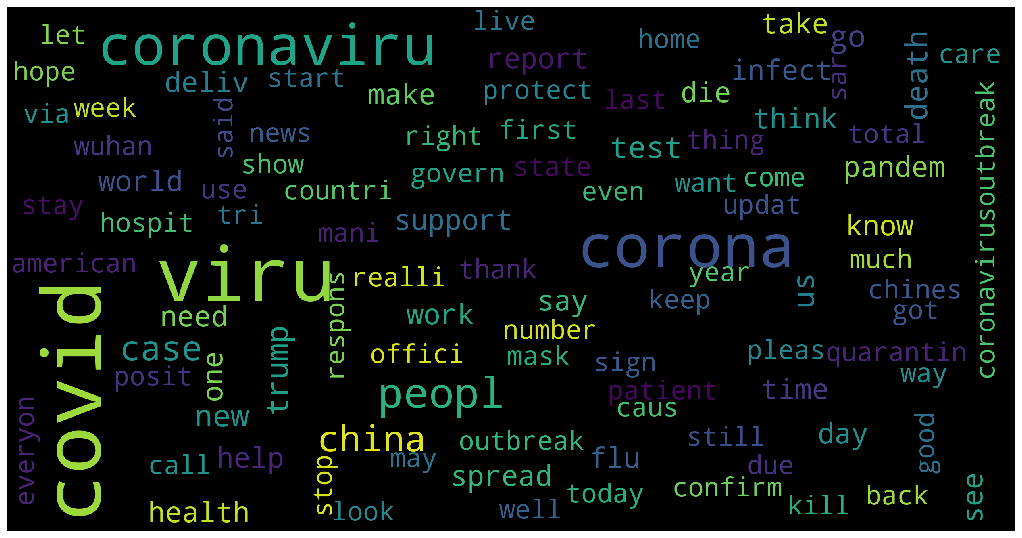

In [76]:
wordcloud = WordCloud(
    max_words=100,
    width=500,
    height=260,
    max_font_size=40, 
    scale=5,
    random_state=2,
    collocations=False,
    normalize_plurals=False
)

wordcloud.generate(' '.join(word_to_list))


plt.figure(figsize = (14, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Running Sentiment Analysis

In [77]:
#polarity score for each tweet
sia_object = SentimentIntensityAnalyzer()
polarity_scores = english_tweets['prep_text'].apply(lambda x: sia_object.polarity_scores(x))

polarity_scores_df = pd.DataFrame(list(polarity_scores))
polarity_scores_df.head()

,neg,neu,pos,compound
0,0.000,0.873,0.127,0.3245
1,0.000,0.766,0.234,0.5994
2,0.401,0.599,0.000,-0.7717
3,0.215,0.785,0.000,-0.6369
4,0.248,0.437,0.316,0.3400


## Categorizing sentiments as positive, negative or neutral

In [78]:
polarity_scores_df['sentiment'] = polarity_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
polarity_scores_df.head()


,neg,neu,pos,compound,sentiment
0,0.000,0.873,0.127,0.3245,positive
1,0.000,0.766,0.234,0.5994,positive
2,0.401,0.599,0.000,-0.7717,negative
3,0.215,0.785,0.000,-0.6369,negative
4,0.248,0.437,0.316,0.3400,positive


In [79]:
sentiment_counts = pd.DataFrame.from_dict(Counter(polarity_scores_df['sentiment']), orient = 'index').reset_index()
sentiment_counts.columns = ['sentiment', 'frequency']
sentiment_counts

,sentiment,frequency
0,positive,7228
1,negative,7437
2,neutral,4754


## Plotting sentiment frequency

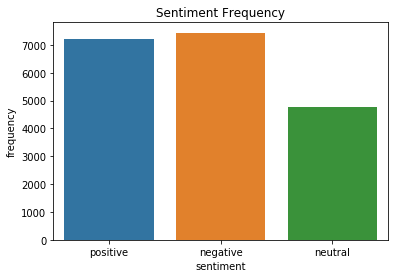

In [82]:
sns.barplot(y="frequency", x='sentiment', data=sentiment_counts).set(title = 'Sentiment Frequency')
plt.show()

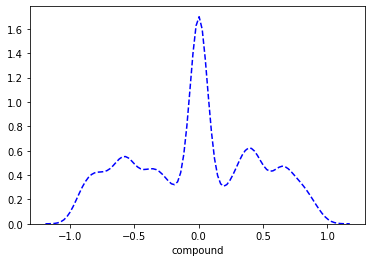

In [85]:
ax1 = sns.distplot(polarity_scores_df['compound'], bins=15, hist = False, color = 'b', kde_kws={'linestyle':'--'})

## Toxic comments